# decentralized
Primary development and execution script for evaluation of game theoretic control algorithms.

References:
1. [Fridovich-Keil - ilqgames](https://github.com/HJReachability/ilqgames/blob/master/python/dynamical_system.py)
1. [anass - ilqr](https://github.com/anassinator/ilqr)
1. [Jackson - AL iLQR Tutorial](https://bjack205.github.io/papers/AL_iLQR_Tutorial.pdf)

In [1]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import (
    iLQR, RecedingHorizonController,
    MultiDynamicalModel, UnicycleDynamics, BicycleDynamics,
    ObstacleCost, ReferenceCost, CouplingCost, AgentCost, GameCost,
    Point
)

In [2]:
%matplotlib ipympl
import matplotlib
matplotlib.rcParams['axes.grid'] = True
np.set_printoptions(precision=3, suppress=True)

In [3]:
f1 = plt.figure(figsize=(6.76, 3.89))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
f2 = plt.figure(figsize=(7.15, 2.21))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [5]:
f3 = plt.figure()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Multi-Agent

In [6]:
dt = 0.05
N = 80
n_lqr_iter = 50
tol = 1e-3

x0 = np.array([
    -5, 0, 0, 0,
    -1, -5, 0, 0])

OBS_WEIGHT = 1e6
REF_WEIGHT = 1
COUPLING_WEIGHT = 1e3
COUPLING_RADIUS = 1.0

obstacles = []
# obstacles = [ObstacleCost((0, 1), Point(0, 0), 0.5, OBS_WEIGHT)]

uni1 = UnicycleDynamics(dt)
uni1_ref = ReferenceCost(xf=np.array([5, 0, 0, 0]),
                        Q=np.diag([1, 1, 0, 0]),
                        R=np.eye(2),
                        Qf=1e3*np.eye(4),
                        weight=REF_WEIGHT)
uni1_cost = AgentCost([uni1_ref] + obstacles)

uni2 = UnicycleDynamics(dt)
uni2_ref = ReferenceCost(xf=np.array([1, 5, 0, 0]),
                        Q=np.diag([1, 1, 0, 0]),
                        R=np.eye(2),
                        Qf=1e3*np.eye(4),
                        weight=REF_WEIGHT)
uni2_cost = AgentCost([uni2_ref] + obstacles)

# bike = BicycleDynamics(dt)
# bike_ref = ReferenceCost(xf=np.array([0, 5, 0, 0]),
#                          Q=np.diag([1, 1, 0, 0, 0]),
#                          R=np.eye(2),
#                          Qf=1e3*np.eye(5),
#                          weight=REF_WEIGHT)
# bike_cost = AgentCost([bike_ref] + obstacles)

dynamics = MultiDynamicalModel([uni1, uni2])

pos_inds = [(0, 1), (4, 5)]
coupling_costs = CouplingCost(pos_inds, radius=COUPLING_RADIUS, weight=COUPLING_WEIGHT)

game_cost = GameCost([uni1_cost, uni2_cost], [coupling_costs], dynamics.x_dims, dynamics.u_dims)

### Vanilla iLQR
Optimize the initial state over the controller's horizon.

In [21]:
ilqr = iLQR(dynamics, game_cost, N=N)
X, U, Jf = ilqr.run(x0, n_lqr_iter=n_lqr_iter, tol=tol)

0/50	J: 220320
1/50	J: 111058	μ: 0.5	Δ: 0.5
2/50	J: 66376.9	μ: 0.125	Δ: 0.25
3/50	J: 6293.17	μ: 0.015625	Δ: 0.125
Failed line search.. increasing μ.
4/50	J: 6293.17	μ: 0.03125	Δ: 2
Failed line search.. increasing μ.
5/50	J: 6293.17	μ: 0.125	Δ: 4
Failed line search.. increasing μ.
6/50	J: 6293.17	μ: 1	Δ: 8
Failed line search.. increasing μ.
7/50	J: 6293.17	μ: 16	Δ: 16
Failed line search.. increasing μ.
8/50	J: 6293.17	μ: 512	Δ: 32
Failed line search.. increasing μ.
Exceeded max regularization term...


In [22]:
plt.figure(f1, clear=True)
ilqr.plot(X,
          do_headings=False, 
          surface_plot=True, 
          log_colors=True,
          coupling_radius=COUPLING_RADIUS,
          axis=(-6, 6, -6, 6),
          title_suffix=f': $J_f$ = {J:.3g}',
          agent_ind=0
         )

### RHC iLQR
Optimize the initial state over a receding horizon according to a step size with additive noise.

In [23]:
step_size = 10
ilqr = iLQR(dynamics, game_cost, N=N)
rhc = RecedingHorizonController(x0, ilqr, step_size)

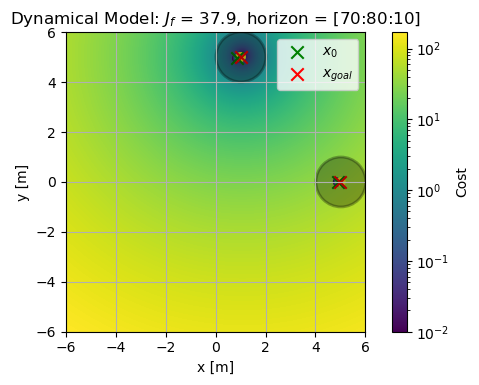

Done!


In [24]:
U = np.zeros((N, ilqr.n_u))
for X, U, J in rhc.run(U, n_lqr_iter=n_lqr_iter, tol=tol):
    print(f"{X.shape=}\t{U.shape=}\t{J=}")
    display.clear_output(wait=True)
    ilqr.plot(X,
          title_suffix=f': $J_f$ = {J:.3g}, horizon = {rhc.status}',
          do_headings=False, 
          surface_plot=True,
          log_colors=True,
          axis=(-6, 6, -6, 6),
          agent_ind=1)
    display.display(plt.gcf())
    plt.pause(0.5)

## Single Agent

In [6]:
from decentralized import DoubleInt1dDynamics, DoubleInt2dDynamics, CarDynamics

In [22]:
dt = 0.1
N = 60
n_lqr_iter = 50
tol = 1e-3

REF_WEIGHT = 1.0
OBS_WEIGHT = 1e6

# dynamics = DoubleInt1dDynamics(dt)
# x0 = np.array([2, 0])
# xf = np.array([0, 1])
# Q = np.eye(2)
# R = np.eye(1)

# dynamics = DoubleInt2dDynamics(dt)
# x0 = np.array([10, 10, 0, 0])
# xf = np.array([0, 0, 0, 0])
# Q = np.diag([1, 1, 0, 0])
# R = np.eye(2)

# dynamics = CarDynamics(dt)
# x0 = np.array([11, 11, np.pi/2])
# xf = np.array([0, 0, 0])
# Q = np.diag([1, 1, 0])
# R = np.eye(2)

dynamics = UnicycleDynamics(dt)
x0 = np.array([-5, -5, 0, 0])
xf = np.array([5, 5, 0, np.pi/4])
Q = np.diag([1, 1, 0, 0])
R = np.eye(2)

# dynamics = BicycleDynamics(dt)
# x0 = np.array([10, 10, np.pi/2, 0, 0])
# xf = np.array([0, 0, 0, 0, 0])
# Q = np.diag([1, 1, 0, 0, 0])
# R = np.eye(2)

Qf = np.eye(Q.shape[0]) * 1e3
reference = ReferenceCost(xf, Q, R, Qf, REF_WEIGHT)
# obstacles = [ObstacleCost((0, 1), Point(3, 3), 2, OBS_WEIGHT),
#              ObstacleCost((0, 1), Point(9, 7), 2, OBS_WEIGHT),
#              ObstacleCost((0, 1), Point(3, 10), 3, OBS_WEIGHT)]
obstacles = [ObstacleCost((0, 1), Point(0, 0), 2, OBS_WEIGHT)]

agent_cost = AgentCost(obstacles + [reference])
game_cost = GameCost([agent_cost], [], [dynamics.n_x], [dynamics.n_u])

### Vanilla iLQR
Optimize the initial state over the controller's horizon.

In [23]:
ilqr = iLQR(dynamics, game_cost, N=N)
X, U, J = ilqr.run(x0, n_lqr_iter=n_lqr_iter, tol=tol)

0/50	J: 212617
1/50	J: 66991.5	μ: 0.5	Δ: 0.5
2/50	J: 5670.04	μ: 0.125	Δ: 0.25
3/50	J: 4183.41	μ: 0.015625	Δ: 0.125
4/50	J: 3566.31	μ: 0.000976562	Δ: 0.0625
5/50	J: 3438.13	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3324.73	μ: 0	Δ: 0.015625
7/50	J: 3296.4	μ: 0	Δ: 0.0078125
8/50	J: 3271.6	μ: 0	Δ: 0.00390625
9/50	J: 3265.12	μ: 0	Δ: 0.00195312


In [24]:
plt.figure(f1, clear=True)
ilqr.plot(
    X,
    do_headings=False, 
    surface_plot=False, 
    log_colors=True,
    coupling_radius=None,
    title_suffix=f': $J_f$ = {J:.3g}',
    axis=(-6, 6, -6, 6))

### RHC iLQR
Optimize the initial state over a receding horizon according to a step size with additive noise.

In [29]:
step_size = 50
ilqr = iLQR(dynamics, game_cost, N=N)
rhc = RecedingHorizonController(x0, ilqr, step_size)

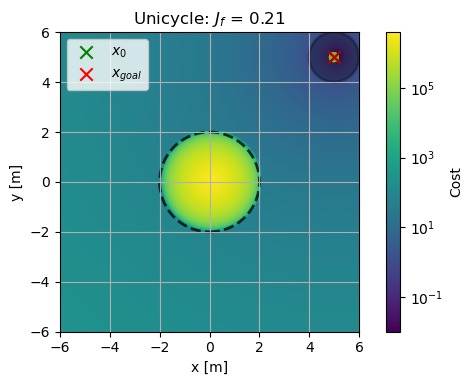

Converged!


In [30]:
U = np.zeros((N, ilqr.n_u))
x = x0
for X, U, J in rhc.run(U, n_lqr_iter=n_lqr_iter, tol=tol):
    # Apply the noisy control sequence.
    # X, J = rhc._controller._rollout(rhc.x, U)
    # rhc.x = X[-1]
    
    display.clear_output(wait=True)
    ilqr.plot(X,
          title_suffix=f': $J_f$ = {J:.3g}',
          do_headings=False, 
          surface_plot=True,
          log_colors=True,
          axis=(-6, 6, -6, 6))
    display.display(plt.gcf())
    plt.pause(1)

## Miscellaneous

In [6]:
def animate(f, axis=None):
    """Callback to render the current frame as an image."""
    
    if axis is None:
        axis = (-7, 7, -7, 7)
    
    ilqr.plot(X[:f],
              Jf=Jf,
              do_headings=False, 
              surface_plot=False, 
              log_colors=True,
              coupling_radius=COUPLING_RADIUS,
              axis=axis
             )
    plt.ylim(axis[-2:])

In [18]:
gifname = 'traj.gif'
plt.figure(f3, clear=True)
anim = FuncAnimation(f3, animate, frames=range(1,N+1))
anim.save(gifname, fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.


In [12]:
dist = np.linalg.norm(X[:, pos_inds[0]] - X[:, pos_inds[1]], axis=1)
crash_mask = dist < COUPLING_RADIUS

costs = np.zeros_like(dist)
for i, (x, u) in enumerate(zip(X, U)):
    costs[i] = game_cost(x, u)

In [13]:
plt.figure(f2, clear=True)
plt.clf()

f2.add_subplot(2,1,1)
plt.plot(dist)
plt.axhline(COUPLING_RADIUS, c='r')
plt.ylabel('Distance')

f2.add_subplot(2,1,2)
plt.plot(costs)
plt.ylabel('Cost')
plt.show()